In [1]:
import scripts.full_workflow_utils as workflow
import torch
import tensorflow as tf
import os


2024-04-02 12:04:55.441500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 12:04:55.607218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/fsl/5.0
2024-04-02 12:04:55.607242: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-02 12:04:55.646924: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 12:04:56.33814

1.12.1+cu102


# Define arguments

In [2]:
''' define paths'''
out_root_folder = r'output' # output visualization folder

''' specify scan'''
scan_root_folder = r'CT_images' # root folder of Dicom file
scan_id = 'p00726056-231124' # Dicom file folder

target_side = 'Left'

''' Model channel configuration, 1 for cholesteatoma, 0 for non-cholesteatoma '''
view_ch = 1 

''' heatmap threshold for visualization '''
optimal_threshold = 0.45

## sample file structure under scan_root_folder/scan_id

In [11]:
ls CT_images/p00726056-231124/

A0G3U4OF/  DICOMDIR  LOCKFILE  VERSION


# Load Deep learning models

In [4]:
''' get models'''
roi_model_path = r'Model_weights/YOLO_3DCT.pt' 
model_roi = torch.hub.load('ultralytics/yolov5', 'custom', path = roi_model_path)

model_3dcom_path = r"Model_weights/3d_image_classification_task2.h5"
model_3dcom = workflow.get_model(width=128, height=128, depth=32)
model_3dcom.load_weights(model_3dcom_path)

last_conv_layer_name = workflow.get_tensorflow_last_layer(model_3dcom) # "conv3d_3" # if necessary, update the name of the last conv layer by checking it through model.summary()


Using cache found in /home/baos1/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-3 Python-3.8.19 torch-1.12.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 10994MiB)

Fusing layers... 
YOLOv5m summary: 308 layers, 21041679 parameters, 0 gradients
Adding AutoShape... 


# Execute full workflow

In [5]:
''' execution'''

''' initial assessment of the dicom file''' 
df_scan = workflow.get_scan_info(os.path.join(scan_root_folder, scan_id))
read_path = df_scan.iloc[0]['Path']
dicom_array = workflow.process_scan(read_path)

''' evaluate central layers and crop ROI'''
df = workflow.scan_through(dicom_array, model_roi)
center_img_left, center_xy_left, center_img_right, center_xy_right = workflow.get_center_img_info(df)

roi_left = workflow.crop_ROI(dicom_array, center_img_left, center_xy_left, slice_num = 16, box_size = 128)
roi_right = workflow.crop_ROI(dicom_array, center_img_right, center_xy_right, slice_num = 16, box_size = 128)

roi_img = roi_left if target_side=='Left' else roi_right

''' preprocess for 3d cnn'''
roi_img = (roi_img/255.).astype("float32")  
img_test = tf.expand_dims(roi_img, axis=-1) 
img_test = tf.expand_dims(img_test, axis=0) 


''' get model prediction'''
prediction = model_3dcom.predict(img_test)

''' plot without heatmap'''
# y_pred_lbl = 1 if prediction[0, 1] >= optimal_threshold else 0 
# plot_test_slices(roi_left, scan_id, y_pred_lbl, False)

''' plot with heatmap'''
heatmap_np = workflow.make_gradcam_heatmap(img_test, model_3dcom, last_conv_layer_name, pred_index = view_ch, resize = False)
heatmap_resize = workflow.resize_volume(heatmap_np, method = 'constant')

workflow.display_superimpose_imgs(out_root_folder,scan_id,target_side,img_test, heatmap_resize, preds = prediction, ch=view_ch, alpha = 0.4,  rows = 4, columns = 8,
                         show_origin = True, show_heatmap = True, cmap = 'coolwarm', threshold = optimal_threshold)


CT_images/p00726056-231124/DICOMDIR


2024-04-02 12:08:30.563440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


1/1 [==============================] - 1s 586ms/step


2024-04-02 12:08:30.812126: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-02 12:08:30.856194: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-02 12:08:30.878148: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-02 12:08:31.226331: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 56623104 exceeds 10% of free system memory.
/data/baos1/yike/3D_otitis_media_model/scripts/full_workflow_utils.py:404: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


# Check outputs with visualization

In [1]:
ls output/

'p00726056-231124 Left.png'


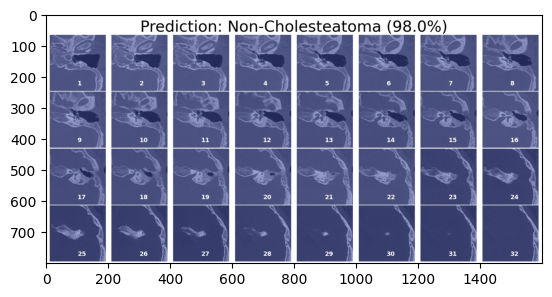

In [8]:
import cv2
import matplotlib.pyplot as plt
vis = cv2.cvtColor(cv2.imread('output/p00726056-231124 Left.png'), cv2.COLOR_BGR2RGB)
plt.imshow(vis)
plt.show()